In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 2 to use

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')
# tf.debugging.set_log_device_placement(False)

2024-05-31 18:55:50.209166: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 18:55:50.456070: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 18:55:50.456102: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 18:55:50.457363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 18:55:50.574738: I tensorflow/core/platform/cpu_feature_g

Num GPUs Available:  1


2024-05-31 18:55:52.659733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-31 18:55:52.762774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-31 18:55:52.762974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import keras

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
test_images.shape

(10000, 28, 28)

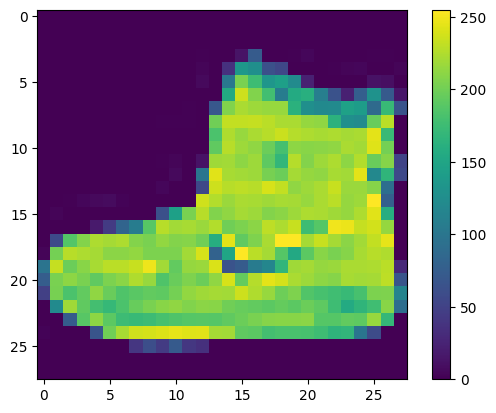

In [6]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0])
plt.colorbar()
plt.show()

In [7]:
train_images = train_images/255
test_images = test_images/255

In [11]:
import numpy as np
train_noise_images = train_images + np.random.normal(0.1,0.05,(60000,28,28))
test_noise_images = test_images + np.random.normal(0.1,0.05,(10000,28,28))

In [12]:
train_noise_images[train_noise_images > 1] = 1
train_noise_images[train_noise_images < 0] = 0

test_noise_images[test_noise_images > 1] = 1
test_noise_images[test_noise_images < 0] = 0

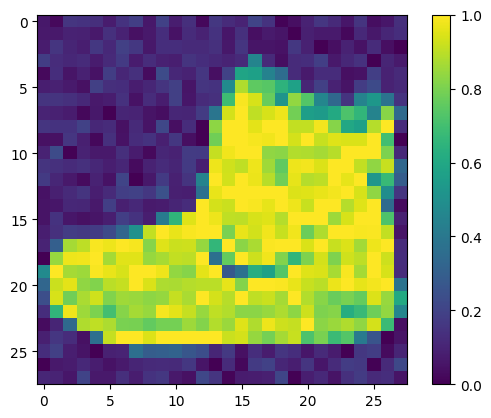

In [13]:
import matplotlib.pyplot as plt
plt.imshow(train_noise_images[0])
plt.colorbar()
plt.show()

In [17]:
from keras.layers import Conv2D, Conv2DTranspose, Input, MaxPool2D, Cropping2D, Concatenate
from keras.models import Model

input = Input(shape=(28,28,1))
c_1_1 = Conv2D(32,(3,3), padding="same",activation="relu")(input)
c_1_2 = Conv2D(32,(3,3), padding="same",activation="relu")(c_1_1)
c_2_1 = MaxPool2D()(c_1_2)

c_2_2 = Conv2D(64,(3,3), padding="same",activation="relu")(c_2_1)
c_2_3 = Conv2D(64,(3,3), padding="same",activation="relu")(c_2_2)
c_3_1 = MaxPool2D()(c_2_3)

c_3_2 = Conv2D(128,(3,3), padding="same",activation="relu")(c_3_1)
c_3_3 = Conv2D(128,(3,3), padding="same",activation="relu")(c_3_2)

c_4_1 = Conv2DTranspose(64, (3,3), strides=(2,2))(c_3_3)
c_4_2 = Cropping2D(cropping=((0,1),(0,1)))(c_4_1)
c_4_3 = Concatenate()([c_4_2, c_2_3])
c_4_4 = Conv2D(64,(3,3), padding="same",activation="relu")(c_4_3)
c_4_5 = Conv2D(64,(3,3), padding="same",activation="relu")(c_4_4)

c_5_1 = Conv2DTranspose(32, (3,3), strides=(2,2))(c_4_5)
c_5_2 = Cropping2D(cropping=((1,0),(1,0)))(c_5_1)
c_5_3 = Concatenate()([c_5_2, c_1_2])
c_5_4 = Conv2D(32,(3,3), padding="same",activation="relu")(c_5_3)
c_5_5 = Conv2D(32,(3,3), padding="same",activation="relu")(c_5_4)

c_6_1 = Conv2D(10,(3,3), padding="same",activation="relu")(c_5_5)
c_6_2 = Conv2D(1,(3,3), padding="same",activation="relu")(c_6_1)

model = Model(input, c_6_2)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 28, 28, 32)           320       ['input_4[0][0]']             
                                                                                                  
 conv2d_23 (Conv2D)          (None, 28, 28, 32)           9248      ['conv2d_22[0][0]']           
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)           0         ['conv2d_23[0][0]']           
 g2D)                                                                                       

In [18]:
model.compile(loss='mse', optimizer='adam')

In [19]:
model.fit(train_noise_images, train_images, validation_data=(test_noise_images, test_images), epochs=5, verbose=2)

Epoch 1/5


2024-05-31 19:08:58.975495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-05-31 19:08:59.265546: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-31 19:09:00.409296: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-31 19:09:01.373201: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f61202be140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-31 19:09:01.373273: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-05-31 19:09:01.381566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-31 19:09:01.481943: I ./tensorflow/compiler/jit/device_comp

1875/1875 - 27s - loss: 0.0021 - val_loss: 8.0523e-04 - 27s/epoch - 14ms/step
Epoch 2/5
1875/1875 - 17s - loss: 7.7540e-04 - val_loss: 7.2416e-04 - 17s/epoch - 9ms/step
Epoch 3/5
1875/1875 - 17s - loss: 7.4054e-04 - val_loss: 7.4923e-04 - 17s/epoch - 9ms/step
Epoch 4/5
1875/1875 - 18s - loss: 7.1585e-04 - val_loss: 7.1051e-04 - 18s/epoch - 9ms/step
Epoch 5/5
1875/1875 - 18s - loss: 6.9966e-04 - val_loss: 6.7577e-04 - 18s/epoch - 10ms/step


In [24]:
value = model.predict(test_noise_images[:1])
value.shape

1/1 [==============================] - 0s 23ms/step


(1, 28, 28, 1)

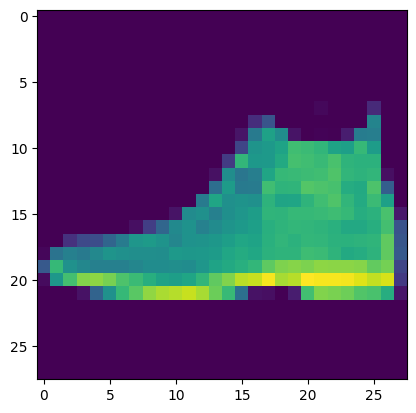

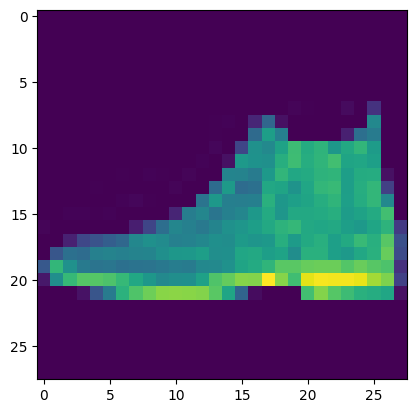

In [25]:
plt.imshow(value[0])
plt.show()
plt.imshow(test_images[0])
plt.show()